In [50]:
import numpy as np
import matplotlib.pyplot as plt
import empymod

In [40]:
def fwd(frequency=20e3, d=3., h=1., rho=100, thk=[], ab=66, h2=None, **kwargs):
    """Compute reponse of coil-coil system empymod.
    
    Parameters
    ==========
    frequency : float
        Measuring frequency
    d : float | array
        horizontal distance between transmitter and receiver
    h : float
        height/elevation of Tx (and Rx by default) above ground
    rho : array|float
        resistivity of subsurface layers
    thk : array|float
        thickness vector
    ab : int
        transmitter-receiver orientation according to empymod API
        66 - HCP/VMD, 55-VCP/HMD perpendicular to profile direction
    h2 : float
        receiver elevation (by default equal to transmitter)
    
    Any other keyword arguments are passed to kwargs and will partially
    override some of the above parameters:
    src : source position and/or orientation
    rec : receiver position and/or orientation
    """
    mu0 = np.pi * 4e-7  # vacuum permittivity
    wmu = mu0 * frequency * 2 * np.pi  # omega my
    depth = np.concatenate([[0], np.cumsum(thk)])
    res = np.concatenate([[2e14], np.atleast_1d(rho)])
    kwargs.setdefault("verb", 1)
    if "src" in kwargs and "rec" in kwargs:
        prim = empymod.bipole(freqtime=frequency, depth=[], res=[2e14], xdirect=True, **kwargs) * 1j * wmu
        totf = empymod.bipole(freqtime=frequency, depth=depth, res=res, **kwargs) * 1j * wmu
    else:
        h2 = h2 or h
        geo = dict(src=[0, 0, -h], rec=[d, 0, -h2], ab=ab)
        prim = empymod.dipole(freqtime=frequency, depth=[], res=[2e14], xdirect=True, **geo, **kwargs) * 1j * wmu
        totf = empymod.dipole(freqtime=frequency, depth=depth, res=res, **geo, **kwargs) * 1j * wmu

    return totf / prim.real - 1, frequency, d

def rhoaLIN(**kwargs):
    """Apparent resistivity."""
    mu0 = np.pi * 4e-7  # vacuum permittivity
    HsHp, frequency, d = fwd(**kwargs)
    wmu = mu0 * frequency * 2 * np.pi  # omega my
    rhoa = wmu * d**2 / 4 / HsHp.imag        
    return rhoa.__array__()

rhoaLIN.__doc__ += fwd.__doc__  # append doc

In [65]:
rhoa = rhoaLIN(rho=100)
print(rhoa)

134.07116810935776


Text(0, 0.5, 'elevation (m)')

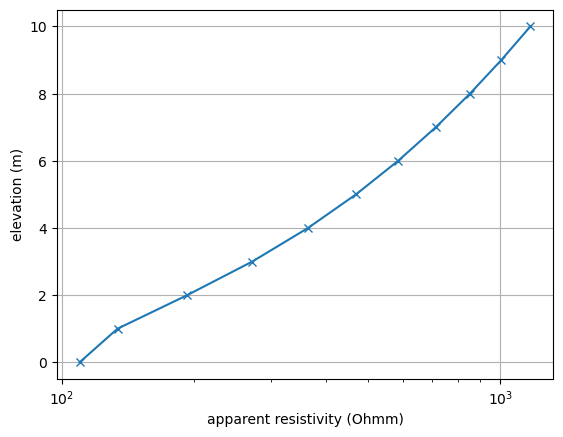

In [64]:
hvec = np.arange(0, 11)
rhoa = np.array([rhoaLIN(rho=100, h=hi) for hi in hvec])
plt.semilogx(rhoa, hvec, "x-")
plt.grid(True)
plt.xlabel("apparent resistivity (Ohmm)")
plt.ylabel("elevation (m)")

In [60]:
def sens0d(rho=100., **kwargs):
    """0D sensitivity."""
    rhoa0 = rhoaLIN(rho=rho, **kwargs)
    rho1 = rho*1.1
    return (np.log(rhoaLIN(rho=rho1)) - np.log(rhoa0)) / (np.log(rho1) - np.log(rho))
    # return (rhoaLIN(rho=rho1) - rhoa0) / (rho1 - rho) * rho / rhoa0

Text(0.5, 0, 'elevation (m)')

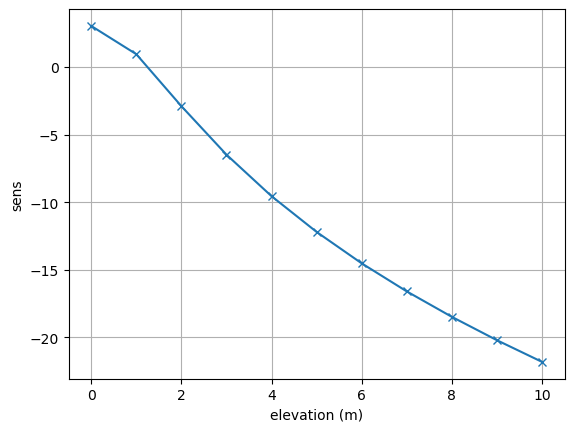

In [61]:
hvec = np.arange(0, 11)
sens = np.array([sens0d(rho=100, h=hi) for hi in hvec])
plt.plot(hvec, sens, "x-")
plt.grid(True)
plt.ylabel("sens")
plt.xlabel("elevation (m)")